## 1T. Тема 3.2 Сверточные и полносвязные нейронные сети

## 3.2.2 Разница между моделями и как устроена архитектура.

В данном модуле обучения рассмотрим, что из себя представляют свёрточные нейронные слои, что называют свёрточные нейронные сети (СНС), как устроена простейшая свёрточная нейронная сеть, как загружают и обрабатывают для неё данные, как её обучают. Проведём сравнение с аналогичной полносвязной сетью, обработав данные после обучения.

Рассмотрим основные особенности борьбы с переобучением, увидим, в чём их различие.

Далее, увидим, как загрузить уже готовые, предварительно обученные ИНС, и сравним результат обработки ими данных с результатами обработки построенных нами послойно ИНС.

####Устанавливаем другую версию Tensorflow, чтобы без сбоев работал модуль classification_report



In [ ]:
#!pip install tensorflow==2.3.0

## Загрузка необходимых модулей

In [ ]:
from tensorflow.keras.datasets import mnist, cifar10 #Библиотеки с базами Mnist, Cifar10
# Подлючаем классы создания последовательной (Sequential) и функциональной (Model) моделей
from tensorflow.keras.models import Sequential, Model
# Подключаем класс Dense - полносвязный слой, и Flatten - данные выстраиваем в линию, одномерные
# Conv2D - свёрточный слой, Input - для подачи входной размерности,
# MaxPooling1D, MaxPooling2D, AveragePooling2D - пулинговые слои для уменьшения размерности
from tensorflow.keras.layers import AveragePooling2D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input
from tensorflow.keras.applications import VGG16 # предобученная нейросеть
# импортируем слои регуляризации Dropout, BatchNormalization для борьбы с переобучением
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam # Подключаем оптимизатор Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator # для создания аугментированных изображениями
from tensorflow.keras import utils #Утилиты для to_categorical
from tensorflow.keras.preprocessing import image #Для отрисовки изображения
from sklearn.metrics import confusion_matrix # для построения матрицы ошибок
from sklearn.utils import resample #для перемешивания выборок
from sklearn.preprocessing import LabelBinarizer # для кодирования в бинарные метки по классам
from sklearn.metrics import classification_report # возвращает точность, полноту, F-меру
from sklearn.model_selection import train_test_split # функция разделения на обучающую и проверочную/тестовую выборку
import os #для вызова прямо в среде программирования команд операционной оболочки
import os.path # чтобы можно было добавлять цифры (переменные) в путь
from imutils import paths # для загрузки картинок из файлов
import glob # для получения списка имён файлов вместе с путём к ним
import zipfile # для работы с архивами zip
import io # для работы с архивами, input - output
import numpy as np # Подключаем библиотеку numpy
# import pylab # Модуль для построения графиков
import pandas as pd # Библиотека pandas
# from mpl_toolkits.mplot3d import Axes3D # Модуль для трехмерной графики
# from google.colab import files #Для загрузки своей картинки
import matplotlib.pyplot as plt #Отрисовка изображений
import seaborn as sns # seaborn, надстройка визуализации над matplotlib
from PIL import Image #Отрисовка изображений
import cv2 # для загрузки и качественной обработки картинок
import random #Для генерации случайных выборок из датасета
import gc # для очистки памяти от лишних данных
#Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline

## Показываем преимущества свёрточного слоя над полносвязным

### Выборки данных, подготовка - датасет PNEUMONIA

Данные для машинного обучения и нейронных сетей можно собирать самым различным образом. Есть, как уже увидели, и готовые датасеты, но в общем случае данные нужно создавать, отбирать, размечать. Специалист, даже если он умеет работать с нейросетями в общем, должен понимать, в каком виде данные он хочет получить. Даже если для разметки он наймёт специальных разметчиков, им нужно чётко объяснить, какие данные он хочет получить. Лучше стараться создавать такие данные, на которых вы сами можете увидеть различия наиболее удобным и заметным способом, тогда и алгоритму или нейросети будет заметно проще их распознать.
Здесь мы загрузим файлы по распознаванию пневмонии с Каггл (ссылку, в которой указаны авторы и лицензия, вы можете посмотреть ниже, мы убрали из датасета папки с дубликатами данных), а также датасет из набора картинок, разделёных на 10 классов каждый -  tensorflow STL-10 и Keras - Cifar 10.

Ссылка на набор данных:
https://data.mendeley.com/datasets/rscbjbr9sj/2

In [ ]:
!wget https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded

--2023-06-21 21:28:31--  https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497 [following]
--2023-06-21 21:28:32--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 52.218.106.40, 52.218.61.192, 3.5.66.10, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|52.218.106.40|:443

In [ ]:
!mv file_downloaded ChestXRay2017.zip

In [ ]:
# загрузили из архива, распаковали
z = zipfile.ZipFile('/content/ChestXRay2017.zip', 'r')
z.extractall()

In [ ]:
# удаляем сам архив, освобождаем диск
!rm -R ChestXRay2017.zip

In [ ]:
# смотрим файлы в папках
!ls

chest_xray  __MACOSX  sample_data


In [ ]:
!ls chest_xray

test  train


In [ ]:
!ls chest_xray/train

NORMAL	PNEUMONIA


In [ ]:
main_dir = 'chest_xray' # указываем основную директорию-папку
#subsets = 'train val test'.split() # указываем папки тренировочной, тестовой и валидационной выборок
subsets = 'train test'.split()
classes = 'NORMAL PNEUMONIA'.split() # делим на классы (названия директорий с картинками)

IMG_SIZE = 192 # задаём размер для получения картинок одного размера из картинок разного размера

In [ ]:
# для балансировки данных по классам вначале разобъём все данные во всех папках просто на классы:
# создаём функцию разделения имён файлов на классы, по всем папкам
# которая вернёт список списков, каждый вложенный список соответствует своему классу
def classes_sep():
    files_classified = [] # создаём список списков, каждый вложенный список будет соответствовать своему классу
    for cls in classes: # перебираем классы
        current_list = [] # создаём временный список имён одного класса
        for subset in subsets: # перебираем директории выборок
            files_list = glob.glob(f'./{main_dir}/{subset}/{cls}/*') # создаём список файлов
            print('обрабатываемая папка: ', f'./{main_dir}/{subset}/{cls}/')
            print('количество файлов в ней:', len(files_list))
            current_list.extend(files_list) # файлы одного класса в одном списке
        files_classified.append(current_list) # добавляем список класса в общий список
    return files_classified

files_classified = classes_sep() # имена из всех папок разделяем только на классы

обрабатываемая папка:  ./chest_xray/train/NORMAL/
количество файлов в ней: 1349
обрабатываемая папка:  ./chest_xray/test/NORMAL/
количество файлов в ней: 234
обрабатываемая папка:  ./chest_xray/train/PNEUMONIA/
количество файлов в ней: 3883
обрабатываемая папка:  ./chest_xray/test/PNEUMONIA/
количество файлов в ней: 390


In [ ]:
# находим минимальную длину выборки, чтобы по ней балансировать данные, если нужно:
def minmax_len():
    min_examples = len(files_classified[0]) # задаём начальное значение
    max_examples = len(files_classified[0]) # задаём начальное значение

    for idx, cls in enumerate(classes): # берём класс и его индекс
        l = len(files_classified[idx]) # длина списка файлов одного класса
        if min_examples > l: # сравниваем длину, берём наименьшую
            min_examples = l
        if max_examples < l: # сравниваем длину, берём наибольшую
            max_examples = l

        print(f'класс {cls} содержит {l} примеров')
    print(f'минимальное число примеров в классе: {min_examples}')
    print(f'наибольшее число примеров в классе: {max_examples}')
    return min_examples, max_examples

min_examples, max_examples = minmax_len()

класс NORMAL содержит 1583 примеров
класс PNEUMONIA содержит 4273 примеров
минимальное число примеров в классе: 1583
наибольшее число примеров в классе: 4273


Налицо явный дисбаланс классов. Если на таких данных обучить сеть, то ей может оказаться проще предсказывать, что все больны, т.к. снимков больных людей почти втрое больше.

In [ ]:
# разделяем имена файлов выборки на тренировочную, тестовую и валидационную

def get_file_lists(test_size = 0.1, val_size = 0.1): # указываем размеры тестовой и валидационной выборок, в принципе хватит по 10%
    # процент указываем по наименьшему классу, остальные делим по соотношению
    train_treshold = int(min_examples * (1 - (test_size + val_size))) # находим номер индекса для отделения тренировочной выборки

    train_names, test_names, val_names = [], [], [] # здесь будут имена файлов для выборок

    for idx, cls in enumerate(classes): # берём класс и его индекс
        l = len(files_classified[idx]) # длина списка файлов одного класса
        # находим номер индекса для разделения тестовой и валидационной выборок в проценте от остатка
        test_val_treshold = train_treshold + int((l - train_treshold) * test_size / (test_size + val_size))
        train_names.append(files_classified[idx][:train_treshold]) # добавляем часть выборки соответствующего класса
        test_names.append(files_classified[idx][train_treshold:test_val_treshold]) # часть оставшейся - в тестовую
        val_names.append(files_classified[idx][test_val_treshold:]) # часть - в валидационную
        print(f'для класса {cls} получено {len(train_names[idx])} тренировочных, {len(test_names[idx])} тестовых и {len(val_names[idx])} валидационных имён файлов')
        print(f'всего имён файлов для класса {cls} получено {len(train_names[idx]) + len(test_names[idx]) + len(val_names[idx])}, а исходно было {len(files_classified[idx])}')
    return train_names, test_names, val_names

train_names, test_names, val_names = get_file_lists(test_size = 0.1, val_size = 0.1)

для класса NORMAL получено 1266 тренировочных, 158 тестовых и 159 валидационных имён файлов
всего имён файлов для класса NORMAL получено 1583, а исходно было 1583
для класса PNEUMONIA получено 1266 тренировочных, 1503 тестовых и 1504 валидационных имён файлов
всего имён файлов для класса PNEUMONIA получено 4273, а исходно было 4273


In [ ]:
# формируем выборку, сразу перемешаем данные (тестовую и валидационную нет смысла перемешивать, но часть перемешаем)
def get_data(file_names):
    X_train = [] # создаём пустые списки, инициализируем переменные
    Y_train = []
    Y_train_cat = [] # если нужны категориальные данные, создаём такой массив
    for idx, cls in enumerate(classes): # проходим по классам
        for i in range(len(file_names[idx])): # идём по выборке индексами
            file_name = file_names[idx][i]
            print(file_name)
            # загружаем картинку, картинки разных размеров
            img_arr = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
            # изменяем размер картинки, приводим к стандарту
            resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
            X_train.append(resized_arr) # добавляем данные в массив
            Y_train_cat.append(utils.to_categorical(idx, len(classes))) # формируем категориальную метку

    X_train = np.array(X_train) # формируем массивы Numpy
    Y_train_cat = np.array(Y_train_cat)

    X_train = X_train/255 # нормализуем данные

    X_train, Y_train_cat = resample(X_train, Y_train_cat, random_state=0) # перемешиваем выборки
    Y_train = np.argmax(Y_train_cat, axis=1) # массив классов

    X_train = X_train.astype('float32') # переводим входные данные в тип, понятный нейронной сети - с плавающей точкой, 32 разряда
    Y_train = Y_train.astype('float32')
    Y_train_cat = Y_train_cat.astype('float32')

    print(X_train.shape)
    print(Y_train.shape)
    print(Y_train_cat.shape)

    return X_train, Y_train, Y_train_cat


In [ ]:
X_train, Y_train, Y_train_cat = get_data(train_names) # создаём тренировочные данные

./chest_xray/train/NORMAL/IM-0642-0001.jpeg
./chest_xray/train/NORMAL/IM-0428-0001.jpeg
./chest_xray/train/NORMAL/IM-0147-0001.jpeg
./chest_xray/train/NORMAL/IM-0601-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-0870-0001.jpeg
./chest_xray/train/NORMAL/IM-0545-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-0680-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-0500-0001.jpeg
./chest_xray/train/NORMAL/IM-0555-0001-0001.jpeg
./chest_xray/train/NORMAL/IM-0441-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-0806-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-1232-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-0655-0001.jpeg
./chest_xray/train/NORMAL/IM-0505-0001-0002.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-1319-0001.jpeg
./chest_xray/train/NORMAL/IM-0440-0001.jpeg
./chest_xray/train/NORMAL/IM-0557-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-1225-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-0804-0001.jpeg
./chest_xray/train/NORMAL/NORM

In [ ]:
X_test, Y_test, Y_test_cat = get_data(test_names) # создаём тестовые данные

./chest_xray/train/NORMAL/IM-0189-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-0433-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-0998-0001.jpeg
./chest_xray/train/NORMAL/IM-0226-0001.jpeg
./chest_xray/train/NORMAL/IM-0727-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-1300-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-0462-0001.jpeg
./chest_xray/train/NORMAL/IM-0215-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-0428-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-1149-0001.jpeg
./chest_xray/train/NORMAL/IM-0495-0001.jpeg
./chest_xray/train/NORMAL/IM-0421-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-1086-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-0536-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-1174-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-0399-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-1038-0001.jpeg
./chest_xray/train/NORMAL/IM-0660-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-0583-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-0867-0001.jpeg
./chest_xray/tra

In [ ]:
X_val, Y_val, Y_val_cat = get_data(val_names) # создаём валидационные данные

./chest_xray/test/NORMAL/NORMAL2-IM-0249-0001.jpeg
./chest_xray/test/NORMAL/NORMAL2-IM-0201-0001.jpeg
./chest_xray/test/NORMAL/IM-0109-0001.jpeg
./chest_xray/test/NORMAL/NORMAL2-IM-0357-0001.jpeg
./chest_xray/test/NORMAL/NORMAL2-IM-0217-0001.jpeg
./chest_xray/test/NORMAL/NORMAL2-IM-0278-0001.jpeg
./chest_xray/test/NORMAL/NORMAL2-IM-0120-0001.jpeg
./chest_xray/test/NORMAL/IM-0077-0001.jpeg
./chest_xray/test/NORMAL/NORMAL2-IM-0353-0001.jpeg
./chest_xray/test/NORMAL/NORMAL2-IM-0251-0001.jpeg
./chest_xray/test/NORMAL/NORMAL2-IM-0349-0001.jpeg
./chest_xray/test/NORMAL/IM-0070-0001.jpeg
./chest_xray/test/NORMAL/IM-0071-0001.jpeg
./chest_xray/test/NORMAL/NORMAL2-IM-0333-0001.jpeg
./chest_xray/test/NORMAL/NORMAL2-IM-0035-0001.jpeg
./chest_xray/test/NORMAL/IM-0097-0001.jpeg
./chest_xray/test/NORMAL/IM-0083-0001.jpeg
./chest_xray/test/NORMAL/IM-0036-0001.jpeg
./chest_xray/test/NORMAL/NORMAL2-IM-0173-0001-0002.jpeg
./chest_xray/test/NORMAL/IM-0011-0001.jpeg
./chest_xray/test/NORMAL/NORMAL2-IM-025

label =  1.0


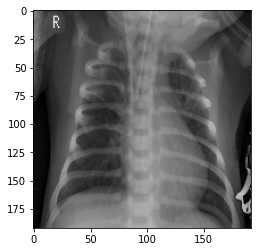

In [ ]:
plt.imshow(X_train[0], cmap='gray') # выводим пример данных
print('label = ', Y_train[0])

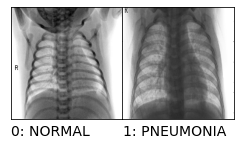

In [ ]:
fig, ax = plt.subplots(1, len(classes), figsize=(len(classes)*2, 5)) # создаём полотно рисунка
fig.subplots_adjust(hspace=0, wspace=0) # настраиваем изображение
for idx in range(len(classes)): #Проходим по классам
    label_indexes = np.where(Y_train==idx)[0] #Получаем список из индексов положений класса idx в Y_data
    index = random.choice(label_indexes) #Случайным образом выбираем из списка индекс
    #Выбираем из x_train нужное изображение, инвертируем цвет, восстанавливаем после нормализации
    img = (1-X_train[index]) * 255
    ax[idx].xaxis.set_major_locator(plt.NullLocator()) # убираем оси и подписи к ним
    ax[idx].yaxis.set_major_locator(plt.NullLocator())
    ax[idx].imshow(Image.fromarray(img)) # Переводим в графический форматмизображение случайно выбранного массива
    ax[idx].text(0.5, X_train.shape[1] * 1.15, f"{idx}: {classes[idx]}", fontsize=14) # вывод текста пойдет в текущий субграфик

plt.show() #Показываем изображения

####Полносвязная нейронная сеть на матричных (двумерных) данных

#####Создаём и обучаем нейронную сеть

In [ ]:
#gc.collect() # очищаем память от лишнего, чтобы памяти было достаточно для нейросети (если возникает ошибка)

model_2d = Sequential() # Создаём полносвязную сеть
model_2d.add(Dense(2000, input_shape=(IMG_SIZE,IMG_SIZE), activation="relu")) # Добавляем полносвязный слой с relu-активацией
model_2d.add(MaxPooling1D())
model_2d.add(Flatten()) # Вытягиваем данные в одномерный вектор только для классификационного слоя
model_2d.add(Dense(500, activation="relu")) # Добавляем полносвязный слой с relu-активацией
model_2d.add(Dense(1, activation="sigmoid")) # Добавляем полносвязный слой на 1 нейрон (т.к. всего 2 класса) с sigmoid-активацией
model_2d.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=["accuracy"]) # Компилируем модель

print(model_2d.summary()) #Вывод структуры модели

my_model_2d = model_2d.fit(X_train, Y_train, batch_size=128, epochs=15, validation_data=(X_val, Y_val), verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 192, 2000)         386000    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 96, 2000)          0         
_________________________________________________________________
flatten (Flatten)            (None, 192000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               96000500  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 501       
Total params: 96,387,001
Trainable params: 96,387,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
20/20 [==============================] - 2s 85ms/step - loss: 3.5549 - accuracy: 0.5829 - val_

#####Выводим графики точности

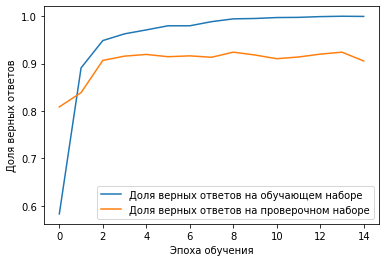

In [ ]:
# Выводим график точности на обучающей выборке
# label - имя графика в легенде
plt.plot(my_model_2d.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')

# Выводим график точности на проверочной выборке
plt.plot(my_model_2d.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')

# Выводим подписи осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Выводим легенду
plt.legend()
plt.show()

##### Строим матрицу ошибок

In [ ]:
Y_test_pred = model_2d.predict(X_test) # прогнозируем моделью тестовые метки

In [ ]:
Y_test_pred.shape

(1661, 1)

In [ ]:
Y_test_pred[0]

array([0.9999964], dtype=float32)

In [ ]:
Y_test_pred_ = Y_test_pred.reshape(Y_test_pred.shape[0])
Y_test_pred_.shape

(1661,)

In [ ]:
mask = Y_test_pred_ > .5 # создаём маску по порогу

In [ ]:
mask = mask.astype('uint8') # переводим маску в 0 и 1

In [ ]:
mask[0]

1

In [ ]:
mask

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [ ]:
Y_test.shape

(1661,)

Text(17.880000000000003, 0.5, 'predicted label')

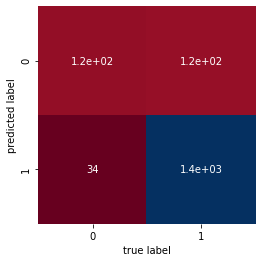

In [ ]:
# пробуем построить матрицу ошибок
plt.figure(figsize=(4, 4)) # задаем размеры всего рисунка
cm = confusion_matrix(mask, Y_test) # создаём матрицу ошибок
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

####Свёрточная нейронная сеть на матричных (двумерных) данных

Принцип работы свёрточных слоёв

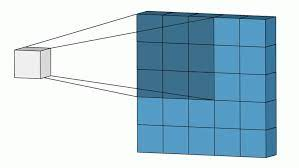

Архитектура свёрточной нейронной сети

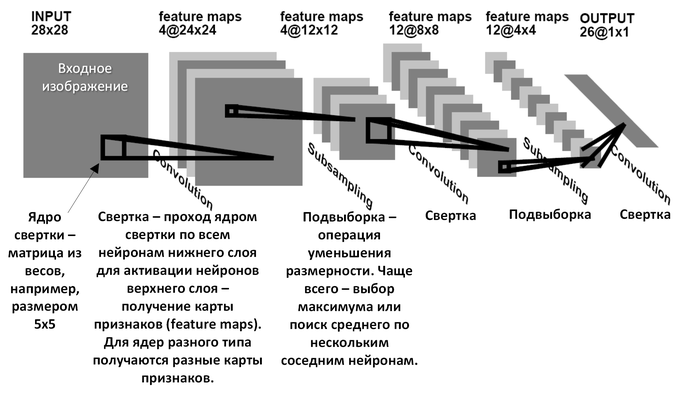

#####Для применения свёрточных слоёв, необходимо добавить ещё одно измерение:

In [ ]:
X_train_c = np.expand_dims(X_train, axis = 3)
print(X_train_c.shape)
X_test_c = np.expand_dims(X_test, axis = 3)
print(X_test_c.shape)
X_val_c = np.expand_dims(X_val, axis = 3)
print(X_val_c.shape)

(2532, 192, 192, 1)
(1661, 192, 192, 1)
(1663, 192, 192, 1)


#####Создаём и обучаем нейронную сеть

In [ ]:
model_2dc = Sequential() # Создаём свёрточную сеть
# Добавляем свёрточнный слой на 32 нейрона (фильтра, ядра), матрица 3x3 с relu-активацией
model_2dc.add(Conv2D(32, 3, padding = 'same', input_shape=(IMG_SIZE,IMG_SIZE,1), activation="relu"))
model_2dc.add(MaxPooling2D()) # пулинг слой уменьшения размерности Dropout, BatchNormalization
# model_2dc.add(Dropout(0.5)) # слои регуляризации
# model_2dc.add(BatchNormalization())
model_2dc.add(Flatten()) # Вытягиваем данные в одномерный вектор только для классификационного слоя
model_2dc.add(Dense(500, activation="relu")) # Добавляем полносвязный слой на 400 нейронов с relu-активацией
model_2dc.add(Dense(1, activation="sigmoid")) # Добавляем полносвязный слой на 10 нейронов с softmax-активацией
model_2dc.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=["accuracy"]) # Компилируем модель

print(model_2dc.summary()) #Вывод структуры модели


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 294912)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               147456500 
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 501       
Total params: 147,457,321
Trainable params: 147,457,321
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
my_model_2dc = model_2dc.fit(X_train_c, Y_train, batch_size=128, epochs=15, validation_data=(X_val_c, Y_val), verbose=1)

Epoch 1/15
20/20 [==============================] - 3s 140ms/step - loss: 3.9610 - accuracy: 0.5664 - val_loss: 0.3666 - val_accuracy: 0.8425
Epoch 2/15
20/20 [==============================] - 2s 123ms/step - loss: 0.4250 - accuracy: 0.8270 - val_loss: 0.3504 - val_accuracy: 0.8515
Epoch 3/15
20/20 [==============================] - 2s 124ms/step - loss: 0.2141 - accuracy: 0.9151 - val_loss: 0.2147 - val_accuracy: 0.9182
Epoch 4/15
20/20 [==============================] - 2s 124ms/step - loss: 0.1256 - accuracy: 0.9633 - val_loss: 0.1976 - val_accuracy: 0.9248
Epoch 5/15
20/20 [==============================] - 2s 124ms/step - loss: 0.0859 - accuracy: 0.9775 - val_loss: 0.1970 - val_accuracy: 0.9314
Epoch 6/15
20/20 [==============================] - 2s 124ms/step - loss: 0.0749 - accuracy: 0.9799 - val_loss: 0.2698 - val_accuracy: 0.9098
Epoch 7/15
20/20 [==============================] - 2s 124ms/step - loss: 0.0438 - accuracy: 0.9921 - val_loss: 0.2133 - val_accuracy: 0.9218
Epoch 

#####Выводим графики точности

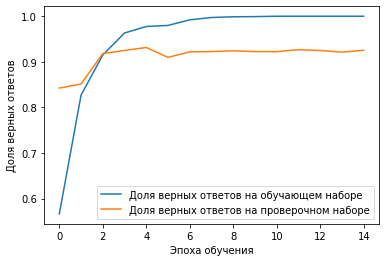

In [ ]:
# Выводим график точности на обучающей выборке
# label - имя графика в легенде
plt.plot(my_model_2dc.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')

# Выводим график точности на проверочной выборке
plt.plot(my_model_2dc.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')

# Выводим подписи осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Выводим легенду
plt.legend()
plt.show()

## 3.2.3 Работа с GPU

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
!nvidia-smi

Wed Jun 21 20:28:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
torch.__version__

'2.0.1+cu118'

In [ ]:
import torchvision
torchvision.__version__

'0.15.2+cu118'

In [ ]:
import tensorflow
tensorflow.__version__

'2.12.0'

## 3.2.4 Борьба с переобучением. Регуляризация.

###Демонстрируем преимущества Dropout на распознавании базы CTL-10

####О самом методе

Dropout - метод регуляризации, при котором часть нейронов предыдущего слоя оказываются "отключены" при обучении. При этом оставшиеся нейроны вынуждены подстраиваться под ситуацию, чтобы обучиться работать и вместо отсутствующих "коллег". В слоях Dropout Keras указывается доля (процент) отключаемых нейронов, при этом число должно быть меньше 1 (т.е. меньше 100%) На каждом батче - пакете данных обучения, взятом из обучающей выборки, отключаются случайно взятые нейроны. Таким образом, в идеале каждый раз берутся разные наборы нейронов для обучения.
Ссылка на оригинальную статью, описывающую метод, приведена в списке литературы.

####Загружаем датасет из набора датасетов tensorflow

Обратите внимание, на загрузку и обработку данных может уйти много времени

In [ ]:
#!pip install tensorflow-datasets
gc.collect()
import tensorflow as tf # импортируем tensorflow
import tensorflow_datasets as tfds # импортируем библиотеку датасетов tensorflow

In [ ]:
X_data1, Y_data1 = tfds.as_numpy(tfds.load( # импортируем данные тренировочной выборки
    'stl10',
    split='train',
    batch_size=-1,
    as_supervised=True,
    shuffle_files=True
))

Shuffling and writing examples to /root/tensorflow_datasets/stl10/1.0.0.incompleteV6845L/stl10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stl10/1.0.0.incompleteV6845L/stl10-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stl10/1.0.0.incompleteV6845L/stl10-unlabelled.tfrecord


Dataset stl10 downloaded and prepared to /root/tensorflow_datasets/stl10/1.0.0. Subsequent calls will reuse this data.


In [ ]:
X_data2, Y_data2 = tfds.as_numpy(tfds.load( # импортируем данные тестовой выборки
    'stl10',
    split='test',
    batch_size=-1,
    as_supervised=True,
    shuffle_files=True
))

In [ ]:
X_data = np.concatenate((X_data1, X_data2), axis = 0) # объединяем данные, чтобы поделить в нужной нам пропорции
Y_data = np.concatenate((Y_data1, Y_data2), axis = 0)

In [ ]:
print(X_data.shape) # смотрим размерности получившегося массива
print(Y_data.shape)
print(type(X_data))
print(type(Y_data))

(13000, 96, 96, 3)
(13000,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
# создаём словарь классов CTL-10, где ключ - название класса, значение = его метка
classes_dict = {'самолет': 0, 'птица': 1, 'автомобиль': 2, 'кот': 3, 'олень': 4, 'собака': 5, 'лошадь': 6, 'обезьяна': 7, 'Корабль': 8, 'грузовик': 9}

In [ ]:
classes = list(classes_dict.keys())
classes

['самолет',
 'птица',
 'автомобиль',
 'кот',
 'олень',
 'собака',
 'лошадь',
 'обезьяна',
 'Корабль',
 'грузовик']

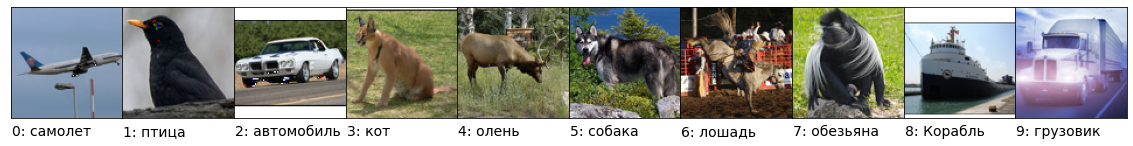

In [ ]:
fig, ax = plt.subplots(1, len(classes), figsize=(len(classes)*2, 5)) # создаём полотно рисунка
fig.subplots_adjust(hspace=0, wspace=0) # настраиваем изображение
for idx in range(len(classes)): #Проходим по классам
    label_indexes = np.where(Y_data==idx)[0] # Получаем список из индексов положений класса idx в Y_data
    index = random.choice(label_indexes) #Случайным образом выбираем из списка индекс
    #Выбираем из x_train нужное изображение, инвертируем цвет, восстанавливаем после нормализации
    img = (1-X_data[index]) * 255
    ax[idx].xaxis.set_major_locator(plt.NullLocator()) # убираем оси и подписи к ним
    ax[idx].yaxis.set_major_locator(plt.NullLocator())
    ax[idx].imshow(Image.fromarray(img)) # Переводим в графический форматмизображение случайно выбранного массива
    ax[idx].text(0.5, X_data.shape[1]  * 1.15, f"{idx}: {classes[idx]}", fontsize=14) # вывод пойдет в текущий субграфик , ha='center'

plt.show() #Показываем изображения

In [ ]:
X_data_ = X_data/255 # нормализуем данные

In [ ]:
Y_data_ = utils.to_categorical(Y_data, num_classes=None) # переводим метки в OHE

In [ ]:
# sklearn - популярная библиотека для машинного обучения
# train_test_split - функция разделения на обучающую и проверочную/тестовую выборку
# from sklearn.model_selection import train_test_split


# test_size=0.2 - будет выделено 20% от тренировочных данных
# shuffle=True - перемешать данные
# x_train - данные для обучения
# x_test - данные для проверки
# y_train - правильные ответы для обучения
# y_test - правильные ответы для проверки

# разделяем выборки в нужной нам пропорции
x_train, x_test, y_train, y_test = train_test_split(X_data_, Y_data_, test_size=0.2, shuffle=True)
print (x_train.shape) # смотрим размерности получившихся данных
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

(10400, 96, 96, 3)
(2600, 96, 96, 3)
(10400, 10)
(2600, 10)


In [ ]:
img_shape = X_data_.shape[1:] # выводим размерности 1-го изображения
img_shape # ширина, высота, число каналов

(96, 96, 3)

##### Нейронная сеть с Dropout

In [ ]:
gc.collect() # очищаем память от лишнего, чтобы памяти было достаточно для нейросети

model_2dcd = Sequential() # Создаём свёрточную сеть
model_2dcd.add(Conv2D(128, 3, padding = 'same', input_shape=img_shape, activation="relu")) # Добавляем свёрточнный слой на 128 нейрона (фильтра, ядра), матрица 3x3 с relu-активацией
model_2dcd.add(Dropout(0.2)) # слои регуляризации
model_2dcd.add(Conv2D(128, 3, padding = 'same', activation="relu"))
model_2dcd.add(MaxPooling2D()) # пулинг слой уменьшения размерности Dropout, BatchNormalization
model_2dcd.add(Dropout(0.2)) # слои регуляризации

model_2dcd.add(Conv2D(64, 3, padding = 'same', activation="relu")) # Добавляем свёрточнный слой на 64 нейрона (фильтра, ядра), матрица 3x3 с relu-активацией
model_2dcd.add(Dropout(0.2)) # слои регуляризации
model_2dcd.add(Conv2D(64, 3, padding = 'same', activation="relu"))
model_2dcd.add(MaxPooling2D()) # пулинг слой уменьшения размерности Dropout, BatchNormalization
model_2dcd.add(Dropout(0.2)) # слои регуляризации

model_2dcd.add(Conv2D(32, 3, padding = 'same', activation="relu")) # Добавляем свёрточнный слой на 32 нейрона (фильтра, ядра), матрица 3x3 с relu-активацией
model_2dcd.add(Dropout(0.2)) # слои регуляризации
model_2dcd.add(Conv2D(32, 3, padding = 'same', activation="relu"))
model_2dcd.add(MaxPooling2D()) # пулинг слой уменьшения размерности Dropout, BatchNormalization
model_2dcd.add(Dropout(0.2)) # слои регуляризации

# model_2dcd.add(BatchNormalization())
model_2dcd.add(Flatten()) # Вытягиваем данные в одномерный вектор только для классификационного слоя
model_2dcd.add(Dense(70, activation="relu")) # Добавляем полносвязный слой на 70 нейронов с relu-активацией
model_2dcd.add(Dense(10, activation="sigmoid")) # Добавляем полносвязный слой на 10 нейронов с softmax-активацией

model_2dcd.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0005), metrics=["accuracy"]) # Компилируем модель

print(model_2dcd.summary()) #Вывод структуры модели

my_model_2dcd = model_2dcd.fit(x_train, y_train, batch_size=128, epochs=30, validation_data=(x_test, y_test), verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 128)       3584      
_________________________________________________________________
dropout (Dropout)            (None, 96, 96, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        73792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 48, 48, 64)       

######График точности

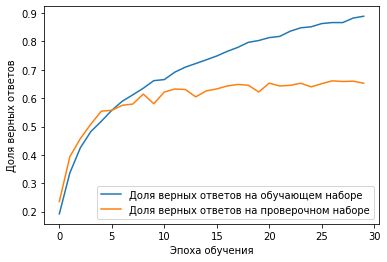

In [ ]:
# Выводим график точности на обучающей выборке
# label - имя графика в легенде
plt.plot(my_model_2dcd.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')

# Выводим график точности на проверочной выборке
plt.plot(my_model_2dcd.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')

# Выводим подписи осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Выводим легенду
plt.legend()
plt.show()

##### Нейронная сеть без регуляризации

In [ ]:
gc.collect() # очищаем память от лишнего, чтобы памяти было достаточно для нейросети

model_2dc = Sequential() # Создаём свёрточную сеть
model_2dc.add(Conv2D(128, 3, padding = 'same', input_shape=img_shape, activation="relu")) # Добавляем свёрточнный слой на 128 нейрона (фильтра, ядра), матрица 3x3 с relu-активацией
# model_2dc.add(Dropout(0.2)) # слои регуляризации
model_2dc.add(Conv2D(128, 3, padding = 'same', activation="relu"))
model_2dc.add(MaxPooling2D()) # пулинг слой уменьшения размерности Dropout, BatchNormalization
# model_2dc.add(Dropout(0.2)) # слои регуляризации

model_2dc.add(Conv2D(64, 3, padding = 'same', activation="relu")) # Добавляем свёрточнный слой на 64 нейрона (фильтра, ядра), матрица 3x3 с relu-активацией
# model_2dc.add(Dropout(0.2)) # слои регуляризации
model_2dc.add(Conv2D(64, 3, padding = 'same', activation="relu"))
model_2dc.add(MaxPooling2D()) # пулинг слой уменьшения размерности Dropout, BatchNormalization
# model_2dc.add(Dropout(0.2)) # слои регуляризации

model_2dc.add(Conv2D(32, 3, padding = 'same', activation="relu")) # Добавляем свёрточнный слой на 32 нейрона (фильтра, ядра), матрица 3x3 с relu-активацией
# model_2dc.add(Dropout(0.2)) # слои регуляризации
model_2dc.add(Conv2D(32, 3, padding = 'same', activation="relu"))
model_2dc.add(MaxPooling2D()) # пулинг слой уменьшения размерности Dropout, BatchNormalization
# model_2dc.add(Dropout(0.2)) # слои регуляризации

# model_2dc.add(BatchNormalization())
model_2dc.add(Flatten()) # Вытягиваем данные в одномерный вектор только для классификационного слоя
model_2dc.add(Dense(70, activation="relu")) # Добавляем полносвязный слой на 70 нейронов с relu-активацией
model_2dc.add(Dense(10, activation="sigmoid")) # Добавляем полносвязный слой на 10 нейронов с softmax-активацией

model_2dc.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0005), metrics=["accuracy"]) # Компилируем модель

print(model_2dc.summary()) #Вывод структуры модели

my_model_2dc = model_2dc.fit(x_train, y_train, batch_size=128, epochs=30, validation_data=(x_test, y_test), verbose=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 96, 96, 128)       3584      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 96, 96, 128)       147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 64)        73792     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 32)       

82/82 [==============================] - 20s 243ms/step - loss: 1.9477 - accuracy: 0.2750 - val_loss: 1.6164 - val_accuracy: 0.4096
Epoch 2/30
82/82 [==============================] - 20s 243ms/step - loss: 1.5186 - accuracy: 0.4446 - val_loss: 1.4410 - val_accuracy: 0.4569
Epoch 3/30
82/82 [==============================] - 20s 243ms/step - loss: 1.3085 - accuracy: 0.5225 - val_loss: 1.3243 - val_accuracy: 0.5123
Epoch 4/30
82/82 [==============================] - 20s 243ms/step - loss: 1.1782 - accuracy: 0.5703 - val_loss: 1.2777 - val_accuracy: 0.5431
Epoch 5/30
82/82 [==============================] - 20s 243ms/step - loss: 1.0662 - accuracy: 0.6170 - val_loss: 1.2402 - val_accuracy: 0.5565
Epoch 6/30
82/82 [==============================] - 20s 244ms/step - loss: 0.9805 - accuracy: 0.6513 - val_loss: 1.2501 - val_accuracy: 0.5565
Epoch 7/30
82/82 [==============================] - 20s 244ms/step - loss: 0.8521 - accuracy: 0.6959 - val_loss: 1.2656 - val_accuracy: 0.5658
Epoch 8/30

######График точности

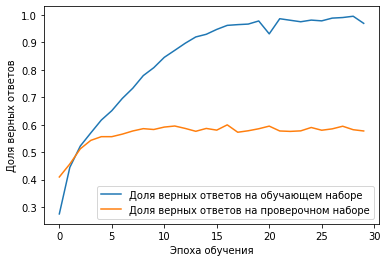

In [ ]:
# Выводим график точности на обучающей выборке
# label - имя графика в легенде
plt.plot(my_model_2dc.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')

# Выводим график точности на проверочной выборке
plt.plot(my_model_2dc.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')

# Выводим подписи осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Выводим легенду
plt.legend()
plt.show()

###Демонстрируем преимущества BatchNormalization на распознавании базы Cifar-10

####О самом методе

BatchNormalization - метод регуляризации, при котором каждый попадающий в обучение батч отдельно нормализуется. При этом считается, что данный метод хорош именно тем, что ускоряет обучение. Конечная точность при его использовании немного падает.  Но на практике часто важна именно скорость, разумное количество эпох обучения, чтобы затратить меньше ресурсов на обучение сети.
Ссылка на оригинальную статью, описывающую метод, приведена в списке литературы.

####Загружаем датасет из набора датасетов Keras

---



In [ ]:
(X_data1, Y_data1), (X_data2, Y_data2) =  cifar10.load_data() #Загрузка данных Mnist cifar10

In [ ]:
X_data = np.concatenate((X_data1, X_data2), axis = 0)
Y_data = np.concatenate((Y_data1, Y_data2), axis = 0)

In [ ]:
# создаём словарь классов Cifar-10, где ключ - название класса, значение = его метка
classes_dict = {'самолет': 0, 'автомобиль': 1, 'птица': 2, 'кот': 3, 'олень': 4, 'собака': 5, 'лягушка': 6, 'лошадь': 7, 'Корабль': 8, 'грузовик': 9}


In [ ]:
classes = list(classes_dict.keys())
classes

['самолет',
 'автомобиль',
 'птица',
 'кот',
 'олень',
 'собака',
 'лягушка',
 'лошадь',
 'Корабль',
 'грузовик']

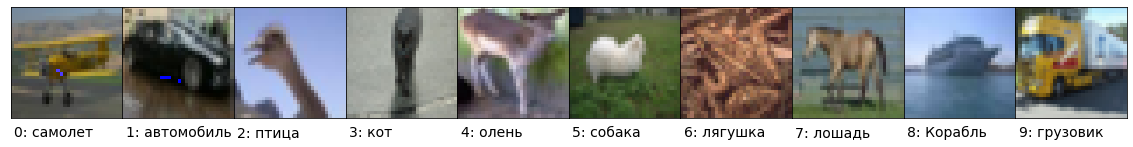

In [ ]:
fig, ax = plt.subplots(1, len(classes), figsize=(len(classes)*2, 5)) # создаём полотно рисунка
fig.subplots_adjust(hspace=0, wspace=0) # настраиваем изображение
for idx in range(len(classes)): #Проходим по классам
    label_indexes = np.where(Y_data==idx)[0] #Получаем список из индексов положений класса idx в Y_data
    index = random.choice(label_indexes) #Случайным образом выбираем из списка индекс
    #Выбираем из x_train нужное изображение, инвертируем цвет, восстанавливаем после нормализации
    img = (1-X_data[index]) * 255
    ax[idx].xaxis.set_major_locator(plt.NullLocator()) # убираем оси и подписи к ним
    ax[idx].yaxis.set_major_locator(plt.NullLocator())
    ax[idx].imshow(Image.fromarray(img)) # Переводим в графический формат изображение случайно выбранного массива
    ax[idx].text(0.5, X_data.shape[1] * 1.15, f"{idx}: {classes[idx]}", fontsize=14) # вывод текста пойдет в текущий субграфик

plt.show() #Показываем изображения

In [ ]:
print(X_data.shape)
print(Y_data.shape)
print(type(X_data))
print(type(Y_data))

(60000, 32, 32, 3)
(60000, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
X_data_ = X_data/255 # нормализуем данные

In [ ]:
Y_data_ = utils.to_categorical(Y_data, num_classes=None)

In [ ]:
# sklearn - популярная библиотека для машинного обучения
# train_test_split - функция разделения на обучающую и проверочную/тестовую выборку
# from sklearn.model_selection import train_test_split


# test_size=0.2 - будет выделено 20% от тренировочных данных
# shuffle=True - перемешать данные
# x_train - данные для обучения
# x_test - данные для проверки
# y_train - правильные ответы для обучения
# y_test - правильные ответы для проверки
x_train, x_test, y_train, y_test = train_test_split(X_data_, Y_data_, test_size=0.2, shuffle=True)
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

(48000, 32, 32, 3)
(12000, 32, 32, 3)
(48000, 10)
(12000, 10)


In [ ]:
img_shape = X_data_.shape[1:]
img_shape

(32, 32, 3)

##### Нейронная сеть с BatchNormalization

In [ ]:
gc.collect() # очищаем память от лишнего, чтобы памяти было достаточно для нейросети

model_2dcd = Sequential() # Создаём свёрточную сеть
# Добавляем свёрточнный слой на 128 нейронов(фильтров, ядер), матрица 3x3 с relu-активацией
model_2dcd.add(Conv2D(128, 3, padding = 'same', input_shape=img_shape, activation="relu"))
model_2dcd.add(BatchNormalization()) # слои регуляризации
model_2dcd.add(Conv2D(128, 3, padding = 'same', activation="relu"))
model_2dcd.add(MaxPooling2D()) # пулинг слой уменьшения размерности Dropout, BatchNormalization
#model_2dcd.add(BatchNormalization()) # слои регуляризации

model_2dcd.add(Conv2D(64, 3, padding = 'same', activation="relu")) # Добавляем свёрточнный слой на 64 нейрона (фильтра, ядра), матрица 3x3 с relu-активацией
model_2dcd.add(BatchNormalization()) # слои регуляризации
model_2dcd.add(Conv2D(64, 3, padding = 'same', activation="relu"))
model_2dcd.add(MaxPooling2D()) # пулинг слой уменьшения размерности Dropout, BatchNormalization
#model_2dcd.add(BatchNormalization()) # слои регуляризации

model_2dcd.add(Conv2D(32, 3, padding = 'same', activation="relu")) # Добавляем свёрточнный слой на 32 нейрона (фильтра, ядра), матрица 3x3 с relu-активацией
model_2dcd.add(BatchNormalization()) # слои регуляризации
model_2dcd.add(Conv2D(32, 3, padding = 'same', activation="relu"))
model_2dcd.add(MaxPooling2D()) # пулинг слой уменьшения размерности Dropout, BatchNormalization
#model_2dcd.add(BatchNormalization()) # слои регуляризации

# model_2dcb.add(BatchNormalization())
model_2dcd.add(Flatten()) # Вытягиваем данные в одномерный вектор только для классификационного слоя
model_2dcd.add(Dense(70, activation="relu")) # Добавляем полносвязный слой на 70 нейронов с relu-активацией
model_2dcd.add(Dense(10, activation="sigmoid")) # Добавляем полносвязный слой на 10 нейронов с softmax-активацией

model_2dcd.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0005), metrics=["accuracy"]) # Компилируем модель

print(model_2dcd.summary()) #Вывод структуры модели

my_model_2dcd = model_2dcd.fit(x_train, y_train, batch_size=128, epochs=30, validation_data=(x_test, y_test), verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        3

######График точности

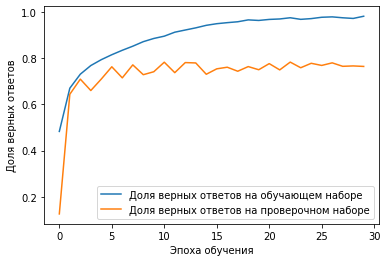

In [ ]:
# Выводим график точности на обучающей выборке
# label - имя графика в легенде
plt.plot(my_model_2dcd.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')

# Выводим график точности на проверочной выборке
plt.plot(my_model_2dcd.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')

# Выводим подписи осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Выводим легенду
plt.legend()
plt.show()

##### Нейронная сеть без регуляризации

In [ ]:
gc.collect() # очищаем память от лишнего, чтобы памяти было достаточно для нейросети

model_2dc = Sequential() # Создаём свёрточную сеть
model_2dc.add(Conv2D(128, 3, padding = 'same', input_shape=img_shape, activation="relu")) # Добавляем свёрточнный слой на 128 нейрона (фильтра, ядра), матрица 3x3 с relu-активацией
# model_2dc.add(Dropout(0.2)) # слои регуляризации
model_2dc.add(Conv2D(128, 3, padding = 'same', activation="relu"))
model_2dc.add(MaxPooling2D()) # пулинг слой уменьшения размерности Dropout, BatchNormalization
# model_2dc.add(Dropout(0.2)) # слои регуляризации

model_2dc.add(Conv2D(64, 3, padding = 'same', activation="relu")) # Добавляем свёрточнный слой на 64 нейрона (фильтра, ядра), матрица 3x3 с relu-активацией
# model_2dc.add(Dropout(0.2)) # слои регуляризации
model_2dc.add(Conv2D(64, 3, padding = 'same', activation="relu"))
model_2dc.add(MaxPooling2D()) # пулинг слой уменьшения размерности Dropout, BatchNormalization
# model_2dc.add(Dropout(0.2)) # слои регуляризации

model_2dc.add(Conv2D(32, 3, padding = 'same', activation="relu")) # Добавляем свёрточнный слой на 32 нейрона (фильтра, ядра), матрица 3x3 с relu-активацией
# model_2dc.add(Dropout(0.2)) # слои регуляризации
model_2dc.add(Conv2D(32, 3, padding = 'same', activation="relu"))
model_2dc.add(MaxPooling2D()) # пулинг слой уменьшения размерности Dropout, BatchNormalization
# model_2dc.add(Dropout(0.2)) # слои регуляризации

# model_2dc.add(BatchNormalization())
model_2dc.add(Flatten()) # Вытягиваем данные в одномерный вектор только для классификационного слоя
model_2dc.add(Dense(70, activation="relu")) # Добавляем полносвязный слой на 70 нейронов с relu-активацией
model_2dc.add(Dense(10, activation="sigmoid")) # Добавляем полносвязный слой на 10 нейронов с softmax-активацией

model_2dc.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0005), metrics=["accuracy"]) # Компилируем модель

print(model_2dc.summary()) #Вывод структуры модели

my_model_2dc = model_2dc.fit(x_train, y_train, batch_size=128, epochs=30, validation_data=(x_test, y_test), verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 32)         

######График точности

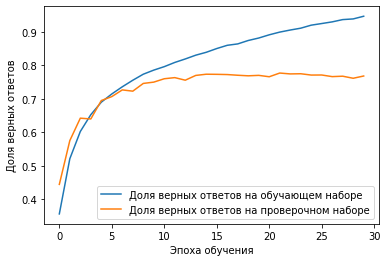

In [ ]:
# Выводим график точности на обучающей выборке
# label - имя графика в легенде
plt.plot(my_model_2dc.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')

# Выводим график точности на проверочной выборке
plt.plot(my_model_2dc.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')

# Выводим подписи осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Выводим легенду
plt.legend()
plt.show()

###Выводы

Оба метода демонстрируют улучшение обучаемости нейронной сети при том же количестве эпох, что и сеть, обучавшаяся без них.

## 3.2.5 Продвинутое обучение нейронных сетей. Работа с данными. Генераторы.

Использование генераторов при загрузке данных даёт сразу несколько преимуществ:
1. Память освобождается - в ней загружен и обрабатывается только текущий батч, а не вся выборка.
2. Генератор создаёт дополнительные данные для обучения из уже имеющихся, что позволяет поднять точность обучения.

In [ ]:
# Указываем путь к папке с папками картинок, в каждой папке одна категориям
train_path = f'./{main_dir}/{subsets[0]}' # путь к тренировочной выборке
val_path = f'./{main_dir}/{subsets[2]}' # путь к валидационной выборке
batch_size = 128 # Размер подвыборки
print(train_path)
print(val_path)

./chest_xray/train
./chest_xray/test


##### Используем расщепление одной выборки из директории на тренировочную и валидационную

######Создаём генераторы

In [ ]:
#Генератор изображений
datagen = ImageDataGenerator(
    rescale = 1/255, #Сразу нормализуем данные при загрузке
    rotation_range=10, #Поворачиваем изображения при генерации выборки
    width_shift_range=0.1, #Двигаем изображения по ширине при генерации выборки
    height_shift_range=0.1, #Двигаем изображения по высоте при генерации выборки
    # shear_range=0.2, # диапазон сдвига
    zoom_range=0.1, #Зумируем изображения при генерации выборки
    horizontal_flip=True, # Включаем отзеркаливание изображений
    fill_mode='nearest', #Заполнение пикселей вне границ ввода
    validation_split=0.1 #Задаём процент тестовй выборки при разделение изображений на обучающую и тестовую выборку
)

In [ ]:
# генератор обучающей выборки
train_generator = datagen.flow_from_directory(
    train_path, # Путь ко всей выборке
    target_size=(IMG_SIZE,IMG_SIZE), #Размер изображений - ширина, высота
    batch_size=batch_size, #Размер batch_size
    class_mode='binary', # Двоичный (бинарный) тип выборки. Категориальный тип выборки - 'categorical'.
    shuffle=True, #Перемешивание выборки
    color_mode="grayscale", # указываем, что у нас только один канал данных, оттенки серого
    subset='training' # устанавливаем как набор для обучения
)

# генератор проверочной выборки
validation_generator = datagen.flow_from_directory(
    train_path, #Путь ко всей выборке
    target_size=(IMG_SIZE,IMG_SIZE), #Размер изображений - ширина, высота
    batch_size=batch_size, #Размер batch_size
    class_mode='binary', # Двоичный (бинарный) тип выборки. Категориальный тип выборки - 'categorical'.
    shuffle=True, #Перемешивание выборки
    color_mode="grayscale", # указываем, что у нас только один канал данных, оттенки серого
    subset='validation' # устанавливаем как валидационный набор
)

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.


######Компилируем и запускаем модель

In [ ]:
model_2dc.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=["accuracy"]) # Компилируем модель

my_model_2dc = model_2dc.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs=15,
    verbose=1
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
36/36 [==============================] - 54s 1s/step - loss: 1.6751 - accuracy: 0.7048 - val_loss: 0.3841 - val_accuracy: 0.8203
Epoch 2/15
36/36 [==============================] - 52s 1s/step - loss: 0.3367 - accuracy: 0.8583 - val_loss: 0.3090 - val_accuracy: 0.8516
Epoch 3/15
36/36 [==============================] - 52s 1s/step - loss: 0.2440 - accuracy: 0.9045 - val_loss: 0.2813 - val_accuracy: 0.8613
Epoch 4/15
36/36 [==============================] - 53s 1s/step - loss: 0.2179 - accuracy: 0.9167 - val_loss: 0.2239 - val_accuracy: 0.8926
Epoch 5/15
36/36 [==============================] - 52s 1s/step - loss: 0.2166 - accuracy: 0.9139 - val_loss: 0.2266 - val_accuracy: 0.9023
Epoch 6/15
36/36 [==============================] - 52s 1s/step - loss: 0.1863 - accuracy: 0.9258 - val_loss: 0.2321 - val_accuracy: 0.8887
Epoch 7/15
36/36 [==============================] - 53s 1s/step - loss: 0.1701 - acc

In [ ]:
model_2dc.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=["accuracy"]) # Компилируем модель

my_model_2dc = model_2dc.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs=15,
    verbose=1
)

Epoch 1/15
36/36 [==============================] - 54s 1s/step - loss: 0.2653 - accuracy: 0.8977 - val_loss: 0.1906 - val_accuracy: 0.9160
Epoch 2/15
36/36 [==============================] - 53s 1s/step - loss: 0.1456 - accuracy: 0.9461 - val_loss: 0.1619 - val_accuracy: 0.9316
Epoch 3/15
36/36 [==============================] - 53s 1s/step - loss: 0.1419 - accuracy: 0.9464 - val_loss: 0.2870 - val_accuracy: 0.8691
Epoch 4/15
36/36 [==============================] - 53s 1s/step - loss: 0.1409 - accuracy: 0.9464 - val_loss: 0.1608 - val_accuracy: 0.9375
Epoch 5/15
36/36 [==============================] - 53s 1s/step - loss: 0.1393 - accuracy: 0.9503 - val_loss: 0.1651 - val_accuracy: 0.9238
Epoch 6/15
36/36 [==============================] - 53s 1s/step - loss: 0.1342 - accuracy: 0.9485 - val_loss: 0.1555 - val_accuracy: 0.9297
Epoch 7/15
36/36 [==============================] - 53s 1s/step - loss: 0.1212 - accuracy: 0.9529 - val_loss: 0.1595 - val_accuracy: 0.9355
Epoch 8/15
36/36 [==

######Выводим графики точности

In [ ]:
# Выводим график точности на обучающей выборке
# label - имя графика в легенде
plt.plot(my_model_2dc.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')

# Выводим график точности на проверочной выборке
plt.plot(my_model_2dc.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')

# Выводим подписи осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Выводим легенду
plt.legend()
plt.show()

##### Используем загрузку тренировочной и валидационной выборок из заранее приготовленных раздельных папок.

######Создаём генераторы

In [ ]:
#Генераторы изображений
train_datagen = ImageDataGenerator( # тренировочные данные нужно аугментировать
    rescale = 1/255, #Сразу нормализуем данные при загрузке
    rotation_range=10, #Поворачиваем изображения при генерации выборки
    width_shift_range=0.1, #Двигаем изображения по ширине при генерации выборки
    height_shift_range=0.1, #Двигаем изображения по высоте при генерации выборки
    # shear_range=0.2, # диапазон сдвига
    zoom_range=0.1, #Зумируем изображения при генерации выборки
    horizontal_flip=True, # Включаем отзеркаливание изображений
    fill_mode='nearest', #Заполнение пикселей вне границ ввода
    validation_split=0.1 #Задаём процент тестовй выборки при разделение изображений на обучающую и тестовую выборку
)
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# генератор обучающей выборки
train_generator = train_datagen.flow_from_directory(
    train_path, # Путь ко всей выборке
    target_size=(IMG_SIZE,IMG_SIZE), #Размер изображений - ширина, высота
    batch_size=batch_size, #Размер batch_size
    class_mode='binary', # Двоичный (бинарный) тип выборки. Категориальный тип выборки - 'categorical'.
    shuffle=True, #Перемешивание выборки
    color_mode="grayscale", # указываем, что у нас только один канал данных, оттенки серого
    #subset='training' # устанавливаем как набор для обучения
)

# генератор проверочной выборки
validation_generator = val_datagen.flow_from_directory(
    val_path, #Путь ко всей выборке
    target_size=(IMG_SIZE,IMG_SIZE), #Размер изображений - ширина, высота
    batch_size=batch_size, #Размер batch_size
    class_mode='binary', # Двоичный (бинарный) тип выборки. Категориальный тип выборки - 'categorical'.
    shuffle=True, #Перемешивание выборки
    color_mode="grayscale", # указываем, что у нас только один канал данных, оттенки серого
    #subset='validation' # устанавливаем как валидационный набор
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


######Компилируем и запускаем модель

In [ ]:
model_2dc.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=["accuracy"]) # Компилируем модель

my_model_2dc = model_2dc.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs=15,
    verbose=1
)

Epoch 1/15
40/40 [==============================] - 58s 1s/step - loss: 0.1706 - accuracy: 0.9367 - val_loss: 0.4447 - val_accuracy: 0.8809
Epoch 2/15
40/40 [==============================] - 56s 1s/step - loss: 0.1359 - accuracy: 0.9505 - val_loss: 0.5988 - val_accuracy: 0.8594
Epoch 3/15
40/40 [==============================] - 57s 1s/step - loss: 0.1259 - accuracy: 0.9538 - val_loss: 0.4652 - val_accuracy: 0.8926
Epoch 4/15
40/40 [==============================] - 56s 1s/step - loss: 0.1268 - accuracy: 0.9526 - val_loss: 0.5601 - val_accuracy: 0.8535
Epoch 5/15
40/40 [==============================] - 57s 1s/step - loss: 0.1138 - accuracy: 0.9570 - val_loss: 0.4100 - val_accuracy: 0.8926
Epoch 6/15
40/40 [==============================] - 57s 1s/step - loss: 0.1130 - accuracy: 0.9575 - val_loss: 0.5161 - val_accuracy: 0.8652
Epoch 7/15
40/40 [==============================] - 56s 1s/step - loss: 0.1164 - accuracy: 0.9558 - val_loss: 0.6089 - val_accuracy: 0.8477
Epoch 8/15
40/40 [==

In [ ]:
model_2dc.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=["accuracy"]) # Компилируем модель

my_model_2dc = model_2dc.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs=15,
    verbose=1
)

Epoch 1/15
40/40 [==============================] - 58s 1s/step - loss: 0.1376 - accuracy: 0.9469 - val_loss: 0.4807 - val_accuracy: 0.8633
Epoch 2/15
40/40 [==============================] - 56s 1s/step - loss: 0.1088 - accuracy: 0.9568 - val_loss: 0.4677 - val_accuracy: 0.8809
Epoch 3/15
40/40 [==============================] - 56s 1s/step - loss: 0.1061 - accuracy: 0.9629 - val_loss: 0.5790 - val_accuracy: 0.8730
Epoch 4/15
40/40 [==============================] - 56s 1s/step - loss: 0.1101 - accuracy: 0.9574 - val_loss: 0.5625 - val_accuracy: 0.8477
Epoch 5/15
40/40 [==============================] - 56s 1s/step - loss: 0.1163 - accuracy: 0.9548 - val_loss: 0.3965 - val_accuracy: 0.8945
Epoch 6/15
40/40 [==============================] - 57s 1s/step - loss: 0.1108 - accuracy: 0.9583 - val_loss: 0.4889 - val_accuracy: 0.8711
Epoch 7/15
40/40 [==============================] - 57s 1s/step - loss: 0.1134 - accuracy: 0.9579 - val_loss: 0.6143 - val_accuracy: 0.8457
Epoch 8/15
40/40 [==

######Выводим графики точности

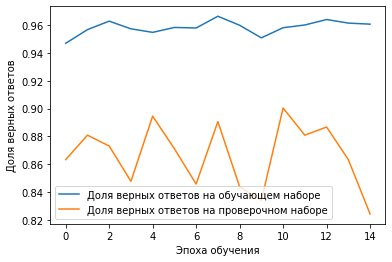

In [ ]:
# Выводим график точности на обучающей выборке
# label - имя графика в легенде
plt.plot(my_model_2dc.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')

# Выводим график точности на проверочной выборке
plt.plot(my_model_2dc.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')

# Выводим подписи осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Выводим легенду
plt.legend()
plt.show()

##### Строим матрицы ошибок

In [ ]:
Y_test_pred_c = model_2dc.predict(X_test_c) # выполняем предсказание моделью

In [ ]:
Y_test_pred_c.shape

(1661, 1)

In [ ]:
Y_test_pred_c[0]

array([0.9999975], dtype=float32)

In [ ]:
Y_test_pred_c_ = Y_test_pred_c.reshape(Y_test_pred_c.shape[0])
Y_test_pred_c_.shape

(1661,)

In [ ]:
mask_c = Y_test_pred_c_ > .65 # делаем маску по пороговому значению

In [ ]:
mask_c = mask_c.astype('uint8') # переводим маску в набор 0 и 1

In [ ]:
mask_c[0]

1

In [ ]:
mask_c

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [ ]:
Y_test.shape

(1661,)

Text(17.880000000000003, 0.5, 'predicted label')

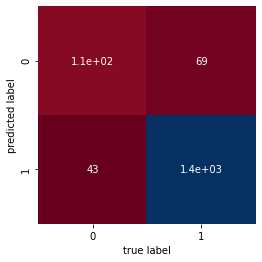

In [ ]:
# пробуем построить матрицу ошибок
plt.figure(figsize=(4, 4)) # задаем размеры всего рисунка
cm = confusion_matrix(mask_c, Y_test) # создаём матрицу ошибок
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

## Продвинутое обучение. Предварительно обученные нейронные сети

### Определяем COVID-19 на рентгеновских снимках используя Keras, TensorFlow, и Глубокое Обучение

#### Скачиваем архив с данными и кодом

In [ ]:
!ls # файлы и папки в корневом каталоге до скачивания

chest_xray  sample_data


In [ ]:
!wget
!unzip -qq covid-19.zip
%cd covid-19

In [ ]:
!ls # файлы и папки в корневом каталоге после скачивания

dataset


In [ ]:
!ls dataset

covid  normal


#### Обрабатываем данные

In [ ]:
# название, и сам объект для парсинга
args = {
    "dataset": "dataset",
    "model": "covid19.model"
}
# инициализируем скорость обучения (момент оптимизатора), количество эпох,
# размер батча
ini_lr = 1e-3
epohs_ = 25
batch_size = 8

In [ ]:
# с помощью paths получаем список картинок в нашей директории dataset, получаем
# картинки и маркируем классы
print("загружаем данные...")
imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []

# берём в цикле по пути к каждому файлу
for imagePath in imagePaths:
	# получаем метку класса из имени файла
	label = imagePath.split(os.path.sep)[-2]

    # загружаем картинку, правильно переставляем каналы(цвета), и приводим к размеру
	# 224 x 224 пикселя, игнорируя исходные масштаб и соотношение ширины к высоте картинки
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

    # добавляем к спискам данные и метки
	data.append(image)
	labels.append(label)

# переводим картинки в формат NumPy и нормализуем
# к диапазону [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

загружаем данные...


In [ ]:
imagePaths[0] # покажем пример пути

'dataset/normal/person989_virus_1667.jpeg'

In [ ]:
print(data.shape) # размерности данных
print(labels.shape)

(50, 224, 224, 3)
(50,)


In [ ]:
# кодируем метки в one-hot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = utils.to_categorical(labels)

# разделяем выборки в соотношении: 80% на тренировочные данные
# остальные 20% на тестовые
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# создаём объект генератора для аугментации
train_gen = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

In [ ]:
print(testY.shape) # смотрим, как устроены метки
testY[0]

(10, 2)


array([0., 1.], dtype=float32)

#### Загружаем предварительно обученную сеть VGG16, и на её основе формируем собственную сеть

In [ ]:
# загружаем VGG16, убираем из исходной модели полносвязные слои
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# создаём полносвязные слои на выходе вместо убранных
# из базовой модели
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel) # усредняющий слой выделения признаков - уменьшения размерности
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# собираем финальную модель, которую хотим тренировать
model = Model(inputs=baseModel.input, outputs=headModel)

# проходим по слоям и "замораживаем" возможность изменения весов
# так, чтобы веса менялись лишь у добавленных слоёв
for layer in baseModel.layers:
	layer.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


#### Компилируем и тренируем модель

In [ ]:
# компилируем модель
print("компилируем модель.")
opt = Adam(lr = ini_lr, decay = ini_lr / epohs_)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# тренируем нашу нейросеть
print("тренируем полносвязные слои нашей нейросети.")
H = model.fit(
	train_gen.flow(trainX, trainY, batch_size=batch_size),
	steps_per_epoch=len(trainX) // batch_size,
	validation_data=(testX, testY),
	validation_steps=len(testX) // batch_size,
	epochs=epohs_)

компилируем модель.
тренируем полносвязные слои нашей нейросети.
Epoch 1/25
5/5 [==============================] - 1s 230ms/step - loss: 0.8749 - accuracy: 0.5250 - val_loss: 0.6777 - val_accuracy: 0.5000
Epoch 2/25
5/5 [==============================] - 0s 83ms/step - loss: 0.6716 - accuracy: 0.6250 - val_loss: 0.7030 - val_accuracy: 0.5000
Epoch 3/25
5/5 [==============================] - 0s 82ms/step - loss: 0.6995 - accuracy: 0.5750 - val_loss: 0.6467 - val_accuracy: 0.5000
Epoch 4/25
5/5 [==============================] - 0s 85ms/step - loss: 0.6531 - accuracy: 0.6750 - val_loss: 0.6201 - val_accuracy: 0.8000
Epoch 5/25
5/5 [==============================] - 0s 86ms/step - loss: 0.5016 - accuracy: 0.7500 - val_loss: 0.6067 - val_accuracy: 0.9000
Epoch 6/25
5/5 [==============================] - 0s 85ms/step - loss: 0.6028 - accuracy: 0.7000 - val_loss: 0.5981 - val_accuracy: 0.8000
Epoch 7/25
5/5 [==============================] - 0s 83ms/step - loss: 0.5350 - accuracy: 0.7500 - v

#### Делаем предсказание моделью

In [ ]:
print("оценка параметров качества сети")
predIdxs = model.predict(testX, batch_size=batch_size)

# для каждой тестовой картинке в массиве
# ищем индекс в векторе ohe элемента с наибольшей вероятностью, это и будет ответ
predIdxs = np.argmax(predIdxs, axis=1)

# показываем ответ: precision - точность, recall - полнота, f1-score - F-мера, support - число примеров
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

оценка параметров качества сети
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00         5
      normal       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



#### Строим матрицу ошибок

acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


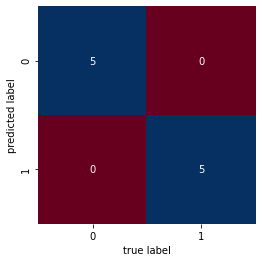

In [ ]:
# строим матрицу ошибок и используем её для расчёта значений
# accuracy, sensitivity, и specificity (точность, верные позитивные(1) и верные негативные(0))
# последние два параметра используются в медицине
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# выводим матрицу ошибок, accuracy, sensitivity, и specificity
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

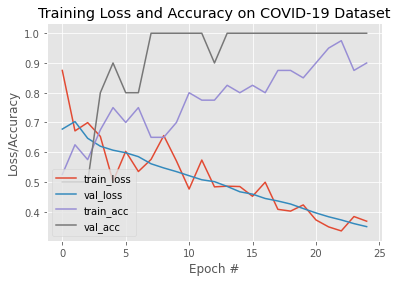

In [ ]:
# plot the training loss and accuracy
N = epohs_
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

####Сохраняем модель

In [ ]:
print("сохраняем модель для определения COVID-19 по рентгеновским снимкам.")
model.save(args["model"], save_format="h5")

сохраняем модель для определения COVID-19 по рентгеновским снимкам.


In [ ]:
!ls

covid19.model  dataset


## Литература


1. https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

2. https://creativecommons.org/licenses/by/4.0/

3. https://cs.stanford.edu/~acoates/stl10/

4. https://www.tensorflow.org/datasets/catalog/overview

5. https://keras.io/api/datasets/

6. https://en.wikipedia.org/wiki/Sensitivity_and_specificity

7. https://en.m.wikipedia.org/wiki/Batch_normalization#:~:text=Batch%20normalization%20(also%20known%20as,and%20Christian%20Szegedy%20in%202015.)

8. https://jmlr.org/papers/v15/srivastava14a.html

9. https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

10. https://neurohive.io/ru/osnovy-data-science/glubokaya-svertochnaja-nejronnaja-set/

11. https://ru.wikipedia.org/wiki/%D0%A1%D0%B2%D1%91%D1%80%D1%82%D0%BE%D1%87%D0%BD%D0%B0%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C

12. Автор: Max La - собственная работа, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=33394271

13. Y. LeCun, B. Boser, J. S. Denker, D. Henderson, R. E. Howard, W. Hubbard and L. D. Jackel: Backpropagation Applied to Handwritten Zip Code Recognition, Neural Computation, 1(4):541-551, Winter 1989.








##Задание

1. Лёгкий уровень
Используя набор данных MNIST, создайте свёрточную сеть классификации рукописных цифр. Сравните accuracy с полносвязной сетью из предыдущей темы. Сделайте выводы.
2. Сложный уровень. Найдите набор данных для классификации изображений на платформе Kaggle. Используя GridSearch, оптимизируйте свёрточную нейронную сеть для наилучшей классификации. Также, подберите для неё наилучший по параметрам регуляризатор. Сделайте выводы.

# Спасибо за внимание!